# Restauración de Imágenes Digitales

En el presente trabajo se ha seguido el  artículo de K. Murthy sobre Restauración bayesiana de imágenes digitales para emplear las técnicas de Montecarlo Markov Chain. Se construyó un código en Python con las indicaciones específicas de Murthy a lo largo del artículo. A continuación se presenta  un resume de dicho artículo con los puntos más importantes de este y con los cuales se llevó a cabo el código. Además, se muestran los resultados al ser implementado con una imagen sencilla.

In [724]:
import matplotlib. pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy
from scipy.signal import convolve2d

## Descripción matemática de una imagen 

Una imagen podemos definirla como la región de un plano la cual está compuesta de pequeños cuadros llamados Pixel (picture element) cuya variaciones en su escala de colores forman patrones y figuras. Para una representación matemática de una imagen definiremos la región espacial de un pixel en plano imagen como $i$. La colección $\Theta = \{\theta_i : i \in S\}$ la llamaremos imagen donde S es el conjunto finito de pixeles que forman la imagen. $\theta_i$ denotará la intensidad de los pixeles (escala de grices). Además, denotamos $\hat{\Theta} = \{\hat{\theta}: i \in S\}$ como la imagen verdadera, es decir, la imagen sin ser dañada con ruido. En un caso real, $\hat{\Theta}$ será desconocida por nosotros. Por otro lado tendremos, la imagen con ruido $X = \{x_i : i \in S\}$. El objetivo del método que se implementará será obtener una aproximación de la imagen verdadera $\hat{\Theta} $ dada una imagen ruidosa $X$. 

Al trabajar sólo con imágenes en escala de grises definiremos 0 como el nivel más bajo (blanco) y Q el nivel más alto (Negro). De esta forma, una imagen de N pixeles será construida con Q niveles de grises discretos $\{0, 1, 2, \cdots , Q-1\}$.  

## Definición de Funciones

### Distancia de Hamming
Creamos la función para cuatificar la distancia entre dos imagenes $\Theta$ y $X$ definidas en un plano en común. Tomamos la definición de la distancia de Hamming:

\begin{equation}
F(\Theta,X) = \sum_{i\in S} I(\theta_i \neq x_i)
\end{equation}

Donde $I(\eta) = 1$ si $\eta$ es verdad y  $I(\eta) = 0$ si $\eta$ es falso

Esta función de distancia cuenta el número de pixeles en $\Theta$ que tienen un nivel de gris diferente al pixel de $X$ correspondiente. Vemos, además, que cumple con todas las características de una distancia métrica.  

In [725]:
def HammDis(Th,X):
    return np.sum(np.ones_like((Th-X)[(Th-X) != 0]))

### El Prior
El Prior debe reflejar que debería ser la imagen limpia. Además, esperamos que una imagen sea suave. Decimos que un píxel está conectado sin problemas a su vecino si los niveles de gris en ellos son los mismos. Entre menor es la diferencia entre los niveles de gris de los pixeles cercanos, más suave es la conexión.

Introduciendo una energía de interacción entre los estados de dos píxeles (nivel de gris) y confinamos la interacción a los píxeles vecinos más cercanos. Así, los estados de un par $i, j$ de píxeles vecinos más cercanos interactúan con una energía denotada por $E_{i,j}$. Tomamos las interacciones como aditivo por pares y definimos una energía de la imagen $\Theta$ como:

\begin{equation}
E(\Theta) = \sum_{<i,j>} E_{i,j}(\Theta)
\end{equation}

En lo anterior, el símbolo $<i, j>$ denota que los píxeles $i$ y $j$ son vecinos más cercanos y la suma se toma sobre todos los pares distintos de píxeles vecinos más cercanos en el plano de la imagen. Modelamos $E_{i, j}$ de tal manera que es pequeño cuando los niveles de gris están cerca uno del otro y grande cuando los niveles de gris difieren en gran medida.



### Modelo de Ising
Considerando una imagen binaria cuyos niveles de grises son cero y uno. La energía de interacción entre los pixeles más cercanos será: 

\begin{equation}
E_{i,j} = \mathcal{I}(\theta_i \neq \theta_j)
\end{equation}

Si los dos pixeles tienen el mismo nivel de gris, la energía de interacción es cero y de lo contrario será uno. La energía de Ising de una imagen $\Theta$ es: 

\begin{equation}
E(\Theta) = \sum_{\langle i,j \rangle} E_{i,j}(\Theta) = \sum_{\langle i,j \rangle} \mathcal{I}(\theta_i \neq \theta_j)
\end{equation}

In [726]:
def Energy_Ising(Th):
    N = len(Th)
    dTh = []
    for i in range(len(Th)):
        for j in range(len(Th)):
            #dTh = []
            dTh.append(Th[i,j]-Th[(i+1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j+1)%N])
            dTh.append(Th[i,j]-Th[(i-1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j-1)%N])
    Eij = np.array(dTh).T
    return -len(Eij[Eij == 0])

### Modelos de Potts

Gemen y McClure recomendaron un Prior en el que los estados de dos píxeles vecinos interactúan con una energía dada por:

\begin{equation}
 E_{i,j}(\Theta) = -\frac{1}{1 + C(\theta_i - \theta_j)^2}
\end{equation}

donde C determina el ancho de la distribución. Adelante se crea la función para calcular la energía $E_{i,j}$ entre dos pixeles sercanos: 

In [727]:
def Energy(Th,C):
    N = len(Th)
    Eij = []
    for i in range(len(Th)):
        for j in range(len(Th)):
            dTh = []
            dTh.append(Th[i,j]-Th[(i+1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j+1)%N])
            dTh.append(Th[i,j]-Th[(i-1)%N,j])
            dTh.append(Th[i,j]-Th[i,(j-1)%N])
            Eij.append(-1/(1+(C*np.array(dTh)**2)))
    return np.sum(np.sum(Eij,axis=1))

Mostramos la energía $E_{i,j}$ de Gemen-McClure para diferentes parametrso C:

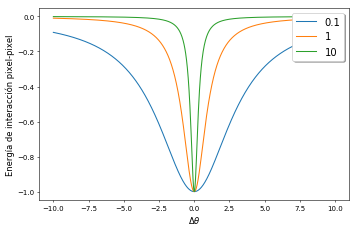

In [815]:
plt.figure(figsize=(8,5), dpi=50)
dTh = np.linspace(-10,10,1000)
for C in [0.1,1,10]:
    plt.plot(dTh,-1/(1+(C*(dTh)**2)),label = C)
plt.xlabel('$\Delta \\theta$', fontsize=12)
plt.ylabel('Energía de interacción pixel-pixel', fontsize=12)
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('graf_energy')

## Distribución bayesiana a posteriori:

Usando el teorema de Bayes:

\begin{equation}
p(\Theta|X) = \frac{\mathscr{L}(X|\theta)p(\theta)}{\sum_{\Theta}\mathscr{L}(X|\theta)p(\theta) }
\end{equation}

La expresión final para el Posteriori que utilizaremos en este algoritmo de restauración de imagen viene dada por:

\begin{equation}
p(\Theta|X) = \frac{\exp\left[ -\frac{1}{L^2(1+\beta)}\left( F(\Theta,X) + \frac{1}{2}\beta E(\Theta) \right) \right]}{\sum_{\Theta} \exp\left[ -\frac{1}{L^2(1+\beta)}\left( F(\Theta,X) + \frac{1}{2}\beta E(\Theta) \right) \right]}
\end{equation}

Donde $\beta$ es valor de $\beta_P$ en unidades e $\beta_L$, es decir, $\beta_L = 1$. Además, se ha normalizado los pesos $\beta_L$ y $\beta_P$ dividiéndolos sobre $\beta_L + \beta_P$. $T = 1/\beta$ le llamaremos sólo temperatura. 

In [731]:
#para una imagen binaria
def posteriori_Ising(Th,X,L,beta):
    a = 1/((1+beta)*L**2)
    return np.exp(-a*(HammDis(Th,X) + ((beta/2)*(Energy_Ising(Th))))) #Usamos la energía de Ising

In [816]:
#para una imagen con varios niveles de grises
def posteriori(Th,X,L,beta,C):
    a = 1/((1+beta)*L**2)
    return np.exp(-a*(HammDis(Th,X) + ((beta/2)*(Energy(Th,C))))) #Usamos la energía de Gemen-McClure

De esta manera, para una temperatura dada, el posteriori incrementa cuando $F(\Theta, X)$ se reduce. Es decir, mientras más cercana este la imagen $\Theta$ a la imagen $X$, más grande será el valor del posteriori $p(\Theta,X)$. Por otro lado el posteriori incrementa cuando la energía de interacción $E$ decrece dada una temperatura $T$. En otras palabras, entre más suave sea la imegen $\Theta$, más grande es el valor de $p(\Theta,X)$. Así, tenemos una pelea entre el prior y el likelihood, el prior trata de suavizar la imagen y el likelihood trata de que la imagen $\Theta$ permanezca cercana a $X$ como sea posible. De esta manera tenemos como resultado una imagen que tiene características de $X$ (debido al likelihood)  y es suave, retirando el ruido (debido al piror).  


La temperatura determinara la competición del prior con el likelihood. Para una temperatura dada: el peso para $F$ es $T/(1+T)$ y el peso para $E$ es $1/(1+T)$.  Cuando $T$ es grande, se da una mayor importancia a la retención de las características de la imagen $X$, es decir, al likelihood. El costo de $T$ muy grandes es que el ruido permanecerá y la imagen no cambiará en grandes aspectos. Por otro lado, si $T$ es pequeño, el suavizamiento (el prior) es más importante. En este caso, para $T$ muy pequeños la imagen perderá sus características e incluso puede llegar a terminar siendo irreconocible. 


## Imagen Binaria

Generamos una imagen Binaria con ruido

In [7]:
from PIL import Image
from resizeimage import resizeimage

Importamos la imagen de un robot y resudimos su tamaño con "resizeimage"

In [700]:
robot = Image.open("robot_1.png") 
ratio = float((robot.size[1]) / (robot.size[0]))
robot = resizeimage.resize_cover(robot, [35, int(ratio * 35)]) #Reducimos la imagen a un tamaño de 35x35
robot = np.asarray(robot).copy()
robot.setflags(write=1)
robot[(robot!=0)&(robot!=255)] = 255 #Combertimos a imagen binaria 
robot = robot / 255 #Noramlizamos a ceros y unos

Mostramos la imagen del robot original y limpia:

Text(0,0.5,'j')

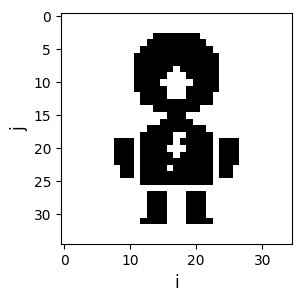

In [750]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(robot, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

### Generamos la imagen con ruido de 5%

Para obtener una imagen con ruido $X$ se obtendrá la imagen verdadera $\hat{\Theta}$ y se corromperá con ruido. Para esto, se seleccionará un pixel $i$ de la imagen $\hat{\Theta}$ para después generar un número aleatorio $\epsilon$. Si $\epsilon < \hat{p}$ entonces el nivel de gris del pixel seleccionado se cambiara a otro nivel que contenga la imagen. Aquí $0<\hat{p}<1$ es el porcentaje de ruido que se elija ponerle a la imagen. Este proceso se realizara para cada uno de los pixeles que componen la imagen $\hat{\Theta}$. 

In [761]:
L = len(robot)
imgnoise = robot.copy()
ruido = 0.03

for i in range(len(imgnoise)):
    for j in range(len(imgnoise[0])):
        eps = np.random.uniform(0,1)
        if eps <= ruido:
            if imgnoise[i,j] == 0:
                imgnoise[i,j] = 1
            else:
                imgnoise[i,j] = 0
        else:
            continue

Text(0,0.5,'j')

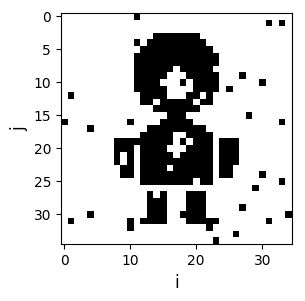

In [762]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(imgnoise, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

## Metodo de Metropolis

Montecarlo Markov Chain (MCMC) provee de técnicas para realizar algoritmos para generar un conjunto de muestras aleatorias a partir de una distribución de probabilidad. Los algoritmos crean una cadena de muestras donde cada muestra depende de las anteriores creadas.  Estos métodos MCMC son atractivos porque proporcionan una forma directa e intuitiva de simular valores de una distribución desconocida y de utilizar esos valores simulados para realizar análisis posteriores. Esto les permite ser aplicables en una amplia variedad de dominios. Por ejemplo, técnicas numéricas para el procesamiento de imágenes. En este caso nos enfocaremos en implementar el algoritmo de Montecarlo para la restauración de imágenes digitales. 

Recordemos que el problema a resolver es: encontrar la imagen $\Theta$ que se aproxime a la imagen verdadera $\hat{\Theta}$ a partir de una imagen con ruido $X$ dada. De esta manera, comenzamos  fijando una temperatura T y creando una imagen aleatoria $\Theta_0$ que por conveniencia escogeremos $\Theta_0 = X$ ya que, por obvias razone,  es la que más se aproxima a $\hat{\Theta}$ por el momento. A esta imagen le llamaremos corriente $\Theta_c = \Theta_0$. 

(1) Calculamos $p_c = p(\Theta_c|X)$ 

(2) Seleccionamos un pixel de manera aleatoria de la imagen corriente 

(3) Cambiamos el nivel de gris de este pixel por otro de forma aleatoria a otro nivel de gris $Q-1$ que compone a la imagen , teniendo estos la misma probabilidad de ser escogidos. 

(4) Esta imagen con el pixel cambiado le llamaremos imagen trial  $\Theta_t $ y calculamos $p_t = p(\Theta_t|X)$  

(5) Si $p_t>p_c$, entonces se acepta a la imagen trial en la siguiente muestra de la cadena $\Theta_1 = \Theta_t$; de otra forma $\Theta_1 = \Theta_0$ 

(6) Ahora, tomamos $\Theta_i$ como la imagen corriente $\Theta_c$ y comenzamos de nuevo el proceso. 
    

De esta manera tendremos la cadena de Markov: 

   \begin{equation*}
        \Theta_1 \rightarrow \Theta_2 \rightarrow \Theta_3 \rightarrow \cdots \rightarrow \Theta_n \rightarrow \cdots
    \end{equation*}

Donde la imagen $\Theta_{k+1}$ depende solamente de $\Theta_k$.

In [759]:
#Procedemos a implementar el metodo de Metropolis para imagen binaria
Th = imgnoise.copy()
Th_prob = imgnoise.copy()
L = len(imgnoise)
p = ruido
e = (1/p) - 1
T = 0.51
betaP = (1/T)/(np.log1p(e))

for i in range(4*5000):
    #Paso 1 
    pi_c = posteriori_Ising(Th,imgnoise,L,betaP)
    
    #Paso 2
    n = np.random.randint(L)
    m = np.random.randint(L)
    
    #Paso 3
    if Th[n,m] == 0:
        Th_prob[n,m] = 1
    else:
        Th_prob[n,m] = 0
    
    #Paso 4
    pi_t = posteriori_Ising(Th_prob,imgnoise,L,betaP)
    
    #Paso 5
    if (pi_t/pi_c)>1:
        Th = Th_prob.copy() # paso 6
    else:
        Th_prob = Th.copy() #paso 6
        

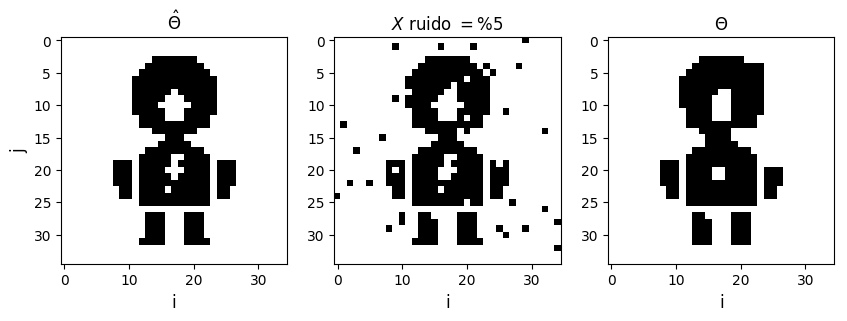

In [760]:
plt.style.use('default')
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(robot, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\hat{\Theta}$')

plt.subplot(332)
plt.imshow(imgnoise, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.title('$X$ ruido $= \%5$')

plt.subplot(333)
plt.imshow(Th, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.title('$\Theta$')
plt.savefig('Robor_1.jpg')

## Imagen con 6 niveles de grises

In [766]:
robot_2 = np.loadtxt('robot_1.csv',delimiter=',')

Text(0,0.5,'j')

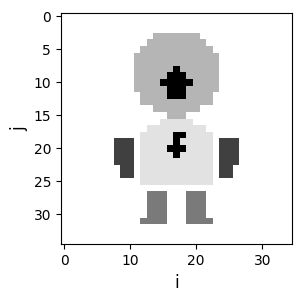

In [767]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(robot_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

In [800]:
L = len(robot_2)
imgnoise_2 = robot_2.copy()
ruido = 0.05
Q = np.max(robot_2)

for i in range(len(imgnoise_2)):
    for j in range(len(imgnoise_2[0])):
        eps = np.random.uniform(0,1)
        if eps <= ruido:
            imgnoise_2[i,j] = np.random.randint(Q)
        else:
            continue

Text(0,0.5,'j')

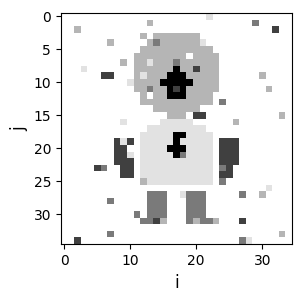

In [801]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(imgnoise_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)

In [732]:
#Prosedemos con el metodo de Metropolis
Th_2 = imgnoise_2.copy()
Th_prob_2 = imgnoise_2.copy()
Q = np.array([0,1,2,3,4,5])
L = len(imgnoise_2)
T = 0.51
p = 0.05
e = (5-1)*((1/p)-1)
beta = (1/T)/(np.log1p(e))

posteri= []
itera = []
for i in range(4*5000):
    #Paso 1
    pi_c = posteriori(Th_2,imgnoise_2,L,beta,1)
    
    #Paso 2
    n = np.random.randint(L)
    m = np.random.randint(L)
    
    #Paso 3
    Th_prob_2[n,m] = np.random.choice(Q[Q != Th_prob_2[n,m]]) #Escojemos otro nivel de Gris diferente al del pixel escojido
    
    #Paso 4
    pi_t = posteriori(Th_prob_2,imgnoise_2,L,beta,1)
    
    #Paso 5
    if (pi_t/pi_c)>1:
        
        Th_2 = Th_prob_2.copy() #Paso 6
        posteri.append(pi_t) #Guardamos el valor de los posterioris para despues graficarlos
        itera.append(i)
    else:
        Th_prob_2 = Th_2.copy() #Paso 6
        

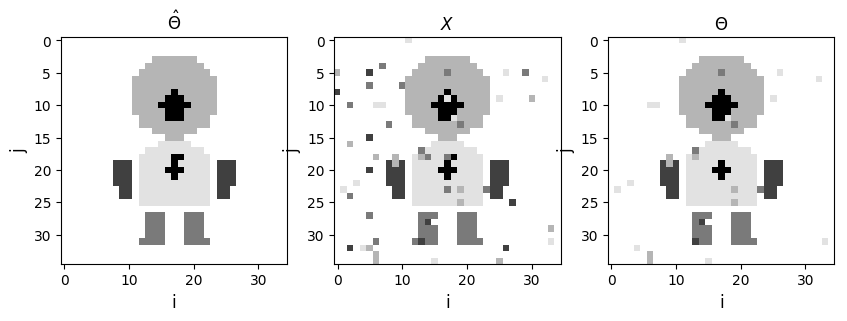

In [733]:
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(robot_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\hat{\Theta}$')

plt.subplot(332)
plt.imshow(imgnoise_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$X$')

plt.subplot(333)
plt.imshow(Th_2, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$\Theta$')
plt.savefig('Robor_2.jpg')

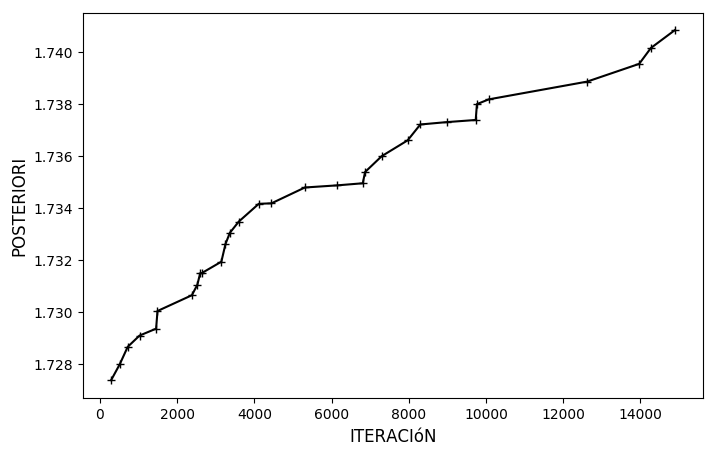

In [749]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(itera,posteri,'k-+')
plt.xlabel('ITERACIóN', fontsize=12)
plt.ylabel('POSTERIORI', fontsize=12)
plt.savefig('graf_posteri')

### Implementamos el metodo para diferentes temperaturas $T = 0.01$, $T = 0.99$ y $T = 1.7$

In [812]:
Q = np.array([0,1,2,3,4,5])
L = len(imgnoise_2)
T = 0.99
p = 0.05
e = (6-1)*((1/p)-1)
beta = (1/T)/(np.log1p(e))



Th_3 = imgnoise_2.copy()
Th_prob_3 = imgnoise_2.copy()
for i in range(4*5000):
    pi_c = posteriori(Th_3,imgnoise_2,L,beta,1)
    n = np.random.randint(L)
    m = np.random.randint(L)
    Th_prob_3[n,m] = np.random.choice(Q[Q != Th_prob_2[n,m]]) #Escojemos otro nivel de Gris diferente al del pixel escojido
    pi_t = posteriori(Th_prob_3,imgnoise_2,L,beta,1)
    if (pi_t/pi_c)>1:
        Th_3 = Th_prob_3.copy()
    else:
        Th_prob_3 = Th_3.copy()
    
        

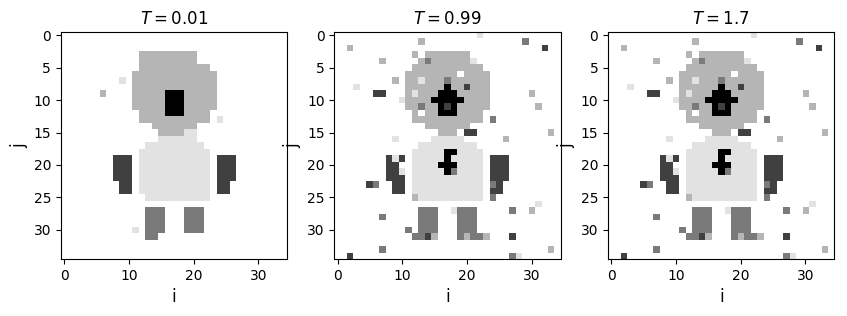

In [813]:
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(331)
plt.imshow(omg[0], cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$T = 0.01$')

plt.subplot(332)
plt.imshow(Th_3, cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$T = 0.99$')

plt.subplot(333)
plt.imshow(omg[2], cmap = 'Greys')
plt.xlabel('i', fontsize=12)
plt.ylabel('j', fontsize=12)
plt.title('$T = 1.7$')
plt.savefig('Robots.jpg')